# Aging Aware with Model Variation
Previously, we optimize the following functional:
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t)) \, {\rm d}t. $$
The optimum is for a specific aging model $\omega$, i.e., we minimized the 
$$ \min_\theta \, \int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t. $$
However, we dont know how will the resistance decay, i.e., we should also minimize the loss function w.r.t. aging models with different parameters. That means we need to optimized
$$ \min_\theta \, \int_{\omega}\int_{t=0}^{1} \; L(\theta(t,\omega)) \, {\rm d}t\, p(\omega){\rm d}\omega. $$
The Mento Carlo Approximation is then
$$
\min_{\theta_{\rm init}} \frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right),
$$
where $\mathfrak{M}$ is the set of $\Omega$ elements following the distribution $p(\omega)$. $p(\omega)$ is the distributions of parameters of the aging model. We have already obtained these distributions as we modeled the aging decay.

That means we should optimize this problem by
$$
\begin{align}
\theta_{\rm init}&:=\theta_{\rm init} - \alpha\cdot\nabla_{\theta_{\rm init}}\left(\frac{1}{\Omega}\frac{1}{K}\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\cdot\nabla_{\theta_{\rm init}}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} } L \left(\theta[k, \omega]\right)\right)\\
&=\theta_{\rm init} - \frac{\alpha}{\Omega K}\left(\sum_{\omega\in\mathfrak{M}}\sum_{k\in \mathfrak{K} }\nabla_{\theta_{\rm init}} L \left(\theta[k, \omega]\right)\right)
\end{align}
$$

# Import library

In [1]:
import importlib
from torch.autograd import Variable
import torch
import pickle
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import pNN_aging_aware_vectorization as pnnv
import training_vectorization as tv
import random
sys.path.append(os.path.join(os.getcwd(), 'Aging_Model'))

# Random Seed

In [2]:
seed = 1

random.seed(seed);
np.random.seed(seed);
torch.manual_seed(seed);

# Get Aging Model

In [3]:
with open(os.path.join(os.getcwd(), 'Aging_Model', 'exp_aging_model.p'), 'rb') as f:
    age_generator = pickle.load(f)

# Device

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cuda:0')
device

device(type='cuda', index=0)

# Prepare data

## Dataset

In [5]:
ds = 'Yeast'

## Load data

In [6]:
datapath = os.path.join(os.getcwd(), 'Datasets', 'Haibin',
                        'data_processed', f'Dataset_{ds}.p')
with open(datapath, 'rb') as f:
    dataset = pickle.load(f)
X = dataset['X'].float()
y = dataset['y']

E, N_features, N_class = X.shape[0], X.shape[1], torch.max(
    torch.unique(y)).item()+1
X.shape, y.shape, E, N_features, N_class

(torch.Size([1484, 8]), torch.Size([1484]), 1484, 8, 10)

## Pseudo-electrical Signal

In [7]:
X = X / (torch.max(X, axis=0)[0] - torch.min(X, axis=0)[0])
X = X - torch.min(X, axis=0)[0]
torch.min(X), torch.max(X)

(tensor(0.), tensor(1.))

In [8]:
X[:10, :9]

tensor([[0.5281, 0.5517, 0.3291, 0.1300, 0.0000, 0.0000, 0.6575, 0.2200],
        [0.3596, 0.6207, 0.3418, 0.2700, 0.0000, 0.0000, 0.7260, 0.2200],
        [0.5955, 0.5632, 0.3544, 0.1500, 0.0000, 0.0000, 0.7260, 0.2200],
        [0.5281, 0.3563, 0.4557, 0.1300, 0.0000, 0.0000, 0.7397, 0.2200],
        [0.3483, 0.3563, 0.3418, 0.5400, 0.0000, 0.0000, 0.6575, 0.2200],
        [0.4494, 0.3103, 0.4430, 0.1700, 0.0000, 0.6024, 0.6712, 0.2200],
        [0.4382, 0.4713, 0.3418, 0.6500, 0.0000, 0.0000, 0.7260, 0.2200],
        [0.4157, 0.3678, 0.4810, 0.2000, 0.0000, 0.0000, 0.7945, 0.3400],
        [0.4944, 0.4253, 0.5696, 0.3600, 0.0000, 0.0000, 0.6712, 0.2200],
        [0.3258, 0.2989, 0.4937, 0.1500, 0.0000, 0.0000, 0.7945, 0.3000]])

In [9]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split

# generate tensordataset
dataset = TensorDataset(X.to(device), y.to(device))

# split
train_rate = 0.6
test_rate = 0.2
valid_rate = 0.2
E_train = min(4096, int(E*train_rate))
E_test = min(1024, int(E*test_rate))
E_valid = min(1024, int(E*valid_rate))

train_data, rest_data = random_split(dataset, [E_train, E-E_train])
test_data, rest_data = random_split(rest_data, [E_test, E-E_train-E_test])
valid_data, rest_data = random_split(rest_data, [E_valid, E-E_train-E_test-E_valid])

len(train_data), len(test_data), len(valid_data)

(890, 296, 296)

In [10]:
# batch
train_loader = DataLoader(train_data, batch_size=len(train_data))
test_loader = DataLoader(test_data, batch_size=len(test_data))
valid_loader = DataLoader(valid_data, batch_size=len(valid_data))

# Hyperparameter

In [11]:
N_Hidden = 5
m = 0.3
T = 0.1
M_train = 100
K_train = 20
M_test = 20
K_test = 10

# Normal NN

## Define

In [12]:
NN = torch.nn.Sequential(torch.nn.Linear(N_features, N_Hidden), torch.nn.Tanh(),
                        torch.nn.Linear(N_Hidden, N_class), torch.nn.Tanh())


def weights_init(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

NN.apply(weights_init)

celoss = torch.nn.CrossEntropyLoss()
NN.to(device)

Sequential(
  (0): Linear(in_features=8, out_features=5, bias=True)
  (1): Tanh()
  (2): Linear(in_features=5, out_features=10, bias=True)
  (3): Tanh()
)

## Training

In [13]:
optimizer_NN = torch.optim.Adam(NN.parameters(), lr=0.1)
train_loader = DataLoader(train_data, batch_size=min(len(train_data),1024))
train_loss_NN, test_loss_NN, parameter_NN = tv.train_normal_nn(NN,
                                                                     train_loader,
                                                                     test_loader,
                                                                     optimizer=optimizer_NN,
                                                                     lossfunction=celoss,
                                                                     Epoch=50000)

  0%|          | 0/50000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.19257 | Loss: 2.150249720
| Epoch:   500 | Accuracy: 0.51351 | Loss: 1.551343441
| Epoch:  1000 | Accuracy: 0.50000 | Loss: 1.560261369
| Epoch:  1500 | Accuracy: 0.49324 | Loss: 1.577465773
| Epoch:  2000 | Accuracy: 0.49662 | Loss: 1.591911554
| Epoch:  2500 | Accuracy: 0.50676 | Loss: 1.599231005
| Epoch:  3000 | Accuracy: 0.48649 | Loss: 1.604980111
| Epoch:  3500 | Accuracy: 0.47635 | Loss: 1.550764680
| Epoch:  4000 | Accuracy: 0.47973 | Loss: 1.551471353
| Epoch:  4500 | Accuracy: 0.47297 | Loss: 1.521981597
| Epoch:  5000 | Accuracy: 0.46959 | Loss: 1.518361092
| Epoch:  5500 | Accuracy: 0.47635 | Loss: 1.514379263
| Epoch:  6000 | Accuracy: 0.47297 | Loss: 1.512659431
| Epoch:  6500 | Accuracy: 0.47973 | Loss: 1.515134692
| Epoch:  7000 | Accuracy: 0.47635 | Loss: 1.513172269
| Epoch:  7500 | Accuracy: 0.47635 | Loss: 1.520194650
| Epoch:  8000 | Accuracy: 0.47635 | Loss: 1.515115023
| Epoch:  8500 | Accuracy: 0.46622 | Loss: 1.521162033
| Epoch:  

(5565, 1.5000112056732178)

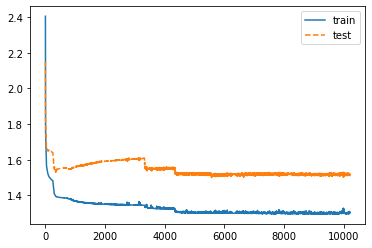

In [14]:
plt.plot(train_loss_NN, '-', label='train')
plt.plot(test_loss_NN, '--', label='test')
plt.legend()
NN.load_state_dict(parameter_NN)
best = np.argmin(test_loss_NN)
best, test_loss_NN[best]

In [15]:
optimizer_NN = torch.optim.Adam(NN.parameters(), lr=0.01)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_NN, test_loss_NN, parameter_NN = tv.train_normal_nn(NN,
                                                                     train_loader,
                                                                     test_loader,
                                                                     optimizer=optimizer_NN,
                                                                     lossfunction=celoss,
                                                                     Epoch=50000)

  0%|          | 0/50000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.47297 | Loss: 1.507454395
| Epoch:   500 | Accuracy: 0.47297 | Loss: 1.518766642
| Epoch:  1000 | Accuracy: 0.47297 | Loss: 1.520737886
| Epoch:  1500 | Accuracy: 0.47297 | Loss: 1.521703124
| Epoch:  2000 | Accuracy: 0.46959 | Loss: 1.522517562
| Epoch:  2500 | Accuracy: 0.47973 | Loss: 1.522857308
| Epoch:  3000 | Accuracy: 0.47973 | Loss: 1.522143960
| Epoch:  3500 | Accuracy: 0.48311 | Loss: 1.523296237
| Epoch:  4000 | Accuracy: 0.47635 | Loss: 1.524397969
| Epoch:  4500 | Accuracy: 0.47973 | Loss: 1.526035905
| Epoch:  5000 | Accuracy: 0.47635 | Loss: 1.524387717
| Epoch:  5500 | Accuracy: 0.47635 | Loss: 1.524852633
| Epoch:  6000 | Accuracy: 0.47973 | Loss: 1.524999619
| Epoch:  6500 | Accuracy: 0.48649 | Loss: 1.525354624
| Epoch:  7000 | Accuracy: 0.48649 | Loss: 1.525616288
| Epoch:  7500 | Accuracy: 0.48649 | Loss: 1.526608348
| Epoch:  8000 | Accuracy: 0.48649 | Loss: 1.526778817
| Epoch:  8500 | Accuracy: 0.48311 | Loss: 1.527304173
| Epoch:  

(3, 1.501798391342163)

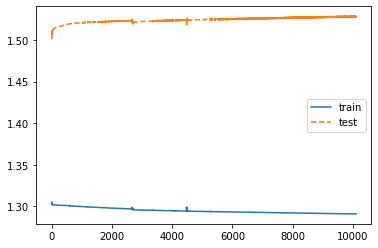

In [16]:
plt.plot(train_loss_NN, '-', label='train')
plt.plot(test_loss_NN, '--', label='test')
plt.legend()
NN.load_state_dict(parameter_NN)
best = np.argmin(test_loss_NN)
best, test_loss_NN[best]

In [17]:
optimizer_NN = torch.optim.Adam(NN.parameters(), lr=0.001)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_NN, test_loss_NN, parameter_NN = tv.train_normal_nn(NN,
                                                                     train_loader,
                                                                     test_loader,
                                                                     optimizer=optimizer_NN,
                                                                     lossfunction=celoss,
                                                                     Epoch=50000)

  0%|          | 0/50000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.47297 | Loss: 1.502423882
| Epoch:   500 | Accuracy: 0.46959 | Loss: 1.513819456
| Epoch:  1000 | Accuracy: 0.46959 | Loss: 1.514999747
| Epoch:  1500 | Accuracy: 0.47297 | Loss: 1.516426325
| Epoch:  2000 | Accuracy: 0.47297 | Loss: 1.518017292
| Epoch:  2500 | Accuracy: 0.47297 | Loss: 1.519400716
| Epoch:  3000 | Accuracy: 0.47297 | Loss: 1.520405173
| Epoch:  3500 | Accuracy: 0.47297 | Loss: 1.521617889
| Epoch:  4000 | Accuracy: 0.47297 | Loss: 1.522254109
| Epoch:  4500 | Accuracy: 0.47297 | Loss: 1.522446036
| Epoch:  5000 | Accuracy: 0.47297 | Loss: 1.522619486
| Epoch:  5500 | Accuracy: 0.47297 | Loss: 1.522757530
| Epoch:  6000 | Accuracy: 0.47297 | Loss: 1.522907495
| Epoch:  6500 | Accuracy: 0.47297 | Loss: 1.523024321
| Epoch:  7000 | Accuracy: 0.47297 | Loss: 1.523157239
| Epoch:  7500 | Accuracy: 0.47297 | Loss: 1.523248076
| Epoch:  8000 | Accuracy: 0.47297 | Loss: 1.523387551
| Epoch:  8500 | Accuracy: 0.47635 | Loss: 1.523480296
| Epoch:  

(0, 1.502423882484436)

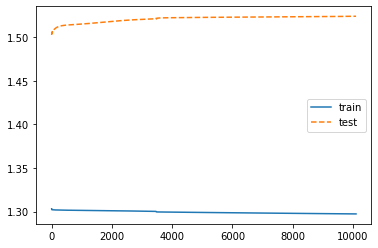

In [18]:
plt.plot(train_loss_NN, '-', label='train')
plt.plot(test_loss_NN, '--', label='test')
plt.legend()
NN.load_state_dict(parameter_NN)
best = np.argmin(test_loss_NN)
best, test_loss_NN[best]

## Save Model

In [19]:
with open(f'./result/{ds}_NN_{seed}.p', 'wb') as f:
    pickle.dump(NN, f)

## Evaluation

In [20]:
for x_valid, y_valid in valid_loader:
    prediction_valid = NN(x_valid)
    p = torch.argmax(prediction_valid, 1)
    pred_y = p.cpu().data.numpy().squeeze()
    acc_valid = sum(pred_y == y_valid.cpu().numpy()) / y_valid.shape[0]
print(acc_valid)

0.527027027027027


In [21]:
NN.to('cpu')

Sequential(
  (0): Linear(in_features=8, out_features=5, bias=True)
  (1): Tanh()
  (2): Linear(in_features=5, out_features=10, bias=True)
  (3): Tanh()
)

# Normal PNN

## Define

In [22]:
PNN = torch.nn.Sequential(pnnv.PNNLayer(N_features, N_Hidden, age_generator, xpu=device),
                         pnnv.PNNLayer(N_Hidden, N_class, age_generator, xpu=device))

PNN.apply(lambda z: pnnv.MakeModel(z, M=1))
PNN.apply(lambda z: pnnv.SetTime(z, t=[0]))

PNN.to(device)

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
)

## Training

In [23]:
optimizer_PNN = torch.optim.Adam(PNN.parameters(), lr=0.1)
train_loader = DataLoader(train_data, batch_size=min(len(train_data),1024))
train_loss_PNN, test_loss_PNN, parameter_PNN = tv.train_normal_pnn(PNN, train_loader, test_loader,
                                                                   m, T, optimizer_PNN,
                                                                   pnnv.LossFunction, Epoch=50000, cache=ds)

  0%|          | 0/50000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.13851 | Loss: 1.391388297 |
| Epoch:   500 | Accuracy: 0.56081 | Loss: 0.630789518 |
| Epoch:  1000 | Accuracy: 0.56081 | Loss: 0.626028597 |
| Epoch:  1500 | Accuracy: 0.53041 | Loss: 0.631323159 |
| Epoch:  2000 | Accuracy: 0.56081 | Loss: 0.626255393 |
| Epoch:  2500 | Accuracy: 0.56081 | Loss: 0.622252107 |
| Epoch:  3000 | Accuracy: 0.56419 | Loss: 0.619910300 |
| Epoch:  3500 | Accuracy: 0.55405 | Loss: 0.618958712 |
| Epoch:  4000 | Accuracy: 0.56757 | Loss: 0.616529047 |
| Epoch:  4500 | Accuracy: 0.56757 | Loss: 0.617592514 |
| Epoch:  5000 | Accuracy: 0.57095 | Loss: 0.616495430 |
| Epoch:  5500 | Accuracy: 0.57770 | Loss: 0.610824347 |
| Epoch:  6000 | Accuracy: 0.56419 | Loss: 0.605431139 |
| Epoch:  6500 | Accuracy: 0.58108 | Loss: 0.607675612 |
| Epoch:  7000 | Accuracy: 0.57095 | Loss: 0.606440246 |
| Epoch:  7500 | Accuracy: 0.54392 | Loss: 0.610637724 |
| Epoch:  8000 | Accuracy: 0.57095 | Loss: 0.608605087 |
| Epoch:  8500 | Accuracy: 0.59

(7534, 0.5991972088813782)

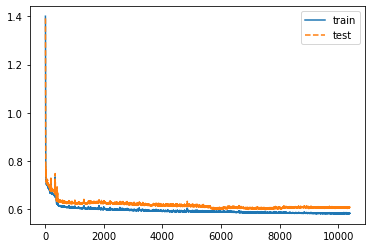

In [24]:
plt.plot(train_loss_PNN, '-', label='train')
plt.plot(test_loss_PNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_PNN)
PNN.load_state_dict(parameter_PNN)
best, test_loss_PNN[best]

In [25]:
optimizer_PNN = torch.optim.Adam(PNN.parameters(), lr=0.01)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_PNN, test_loss_PNN, parameter_PNN = tv.train_normal_pnn(PNN, train_loader, test_loader,
                                                                   m, T, optimizer_PNN,
                                                                   pnnv.LossFunction, Epoch=50000, cache=ds)

  0%|          | 0/50000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.58108 | Loss: 0.603224397 |
| Epoch:   500 | Accuracy: 0.58108 | Loss: 0.601583838 |
| Epoch:  1000 | Accuracy: 0.57770 | Loss: 0.603733361 |
| Epoch:  1500 | Accuracy: 0.57432 | Loss: 0.605963647 |
| Epoch:  2000 | Accuracy: 0.53041 | Loss: 0.607315183 |
| Epoch:  2500 | Accuracy: 0.54730 | Loss: 0.606997848 |
| Epoch:  3000 | Accuracy: 0.55068 | Loss: 0.606827736 |
| Epoch:  3500 | Accuracy: 0.56757 | Loss: 0.606103301 |
| Epoch:  4000 | Accuracy: 0.54730 | Loss: 0.605941594 |
| Epoch:  4500 | Accuracy: 0.56757 | Loss: 0.605746269 |
| Epoch:  5000 | Accuracy: 0.56757 | Loss: 0.605487347 |
| Epoch:  5500 | Accuracy: 0.55743 | Loss: 0.605568171 |
| Epoch:  6000 | Accuracy: 0.56081 | Loss: 0.605217695 |
| Epoch:  6500 | Accuracy: 0.55405 | Loss: 0.605603576 |
| Epoch:  7000 | Accuracy: 0.52703 | Loss: 0.604967535 |
| Epoch:  7500 | Accuracy: 0.56757 | Loss: 0.604534805 |
| Epoch:  8000 | Accuracy: 0.54730 | Loss: 0.604492009 |
| Epoch:  8500 | Accuracy: 0.56

(3, 0.5995039939880371)

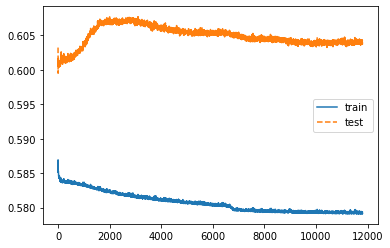

In [26]:
plt.plot(train_loss_PNN, '-', label='train')
plt.plot(test_loss_PNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_PNN)
PNN.load_state_dict(parameter_PNN)
best, test_loss_PNN[best]

In [27]:
optimizer_PNN = torch.optim.Adam(PNN.parameters(), lr=0.001)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_PNN, test_loss_PNN, parameter_PNN = tv.train_normal_pnn(PNN, train_loader, test_loader,
                                                                   m, T, optimizer_PNN,
                                                                   pnnv.LossFunction, Epoch=50000, cache=ds)

  0%|          | 0/50000 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.57095 | Loss: 0.599412084 |
| Epoch:   500 | Accuracy: 0.58784 | Loss: 0.600308597 |
| Epoch:  1000 | Accuracy: 0.58784 | Loss: 0.601174951 |
| Epoch:  1500 | Accuracy: 0.56419 | Loss: 0.601356745 |
| Epoch:  2000 | Accuracy: 0.55743 | Loss: 0.601342082 |
| Epoch:  2500 | Accuracy: 0.55743 | Loss: 0.601260543 |
| Epoch:  3000 | Accuracy: 0.55743 | Loss: 0.601279259 |
| Epoch:  3500 | Accuracy: 0.54054 | Loss: 0.601289213 |
| Epoch:  4000 | Accuracy: 0.55743 | Loss: 0.601506829 |
| Epoch:  4500 | Accuracy: 0.58108 | Loss: 0.601680338 |
| Epoch:  5000 | Accuracy: 0.58108 | Loss: 0.602073967 |
| Epoch:  5500 | Accuracy: 0.58108 | Loss: 0.602460027 |
| Epoch:  6000 | Accuracy: 0.57770 | Loss: 0.602736056 |
| Epoch:  6500 | Accuracy: 0.58108 | Loss: 0.602879226 |
| Epoch:  7000 | Accuracy: 0.58108 | Loss: 0.603102386 |
| Epoch:  7500 | Accuracy: 0.57432 | Loss: 0.603760004 |
| Epoch:  8000 | Accuracy: 0.55743 | Loss: 0.604138076 |
| Epoch:  8500 | Accuracy: 0.57

(0, 0.5994120836257935)

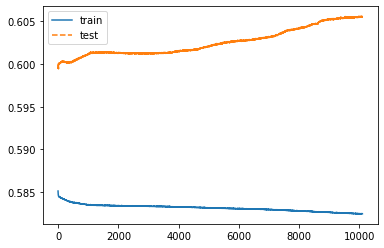

In [28]:
plt.plot(train_loss_PNN, '-', label='train')
plt.plot(test_loss_PNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_PNN)
PNN.load_state_dict(parameter_PNN)
best, test_loss_PNN[best]

## Save Model

In [29]:
with open(f'./result/{ds}_PNN_{seed}.p', 'wb') as f:
    pickle.dump(PNN, f)

In [30]:
PNN.to('cpu')

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
)

# Aging Aware PNN

In [31]:
AAPNN = torch.nn.Sequential(pnnv.PNNLayer(N_features, N_Hidden, age_generator, xpu=device),
                           pnnv.PNNLayer(N_Hidden, N_class, age_generator, xpu=device))

AAPNN.apply(lambda z: pnnv.MakeModel(z, M_train))
AAPNN.apply(lambda z: pnnv.SetTime(z, np.random.rand(K_train).tolist()))

AAPNN.to(device)

Sequential(
  (0): PNNLayer()
  (1): PNNLayer()
)

## Reload AAPNN if crash

In [32]:
# if os.path.exists(f'./temp/{ds}_AAPNN.p'): 
#     with open(f'./temp/{ds}_AAPNN.p', 'rb') as f:
#         AAPNN = pickle.load(f)

## Training

In [33]:
optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=0.1)
train_loader = DataLoader(train_data, batch_size=min(len(train_data),1024))
train_loss_AAPNN, test_loss_AAPNN, parameter_AAPNN = tv.train_aged_pnn(AAPNN, train_loader, test_loader,
                                        m, T, M_train, K_train, M_test, K_test,
                                        optimizer_AAPNN, pnnv.LossFunction,
                                        Epoch=500, cache=ds)

  0%|          | 0/500 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.08144 | Loss: 1.314469337 |
| Epoch:    25 | Accuracy: 0.28380 | Loss: 1.007588983 |
| Epoch:    50 | Accuracy: 0.30003 | Loss: 0.992299139 |
| Epoch:    75 | Accuracy: 0.32669 | Loss: 0.957732022 |
| Epoch:   100 | Accuracy: 0.36233 | Loss: 0.909777701 |
| Epoch:   125 | Accuracy: 0.36909 | Loss: 0.913924336 |
| Epoch:   150 | Accuracy: 0.40973 | Loss: 0.890766501 |
| Epoch:   175 | Accuracy: 0.39314 | Loss: 0.887536108 |
| Epoch:   200 | Accuracy: 0.41956 | Loss: 0.860584855 |
| Epoch:   225 | Accuracy: 0.41399 | Loss: 0.893221080 |
| Epoch:   250 | Accuracy: 0.42608 | Loss: 0.882182121 |
| Epoch:   275 | Accuracy: 0.42812 | Loss: 0.859642923 |
| Epoch:   300 | Accuracy: 0.43275 | Loss: 0.847679257 |
| Epoch:   325 | Accuracy: 0.43975 | Loss: 0.832834184 |
| Epoch:   350 | Accuracy: 0.46620 | Loss: 0.819265664 |
| Epoch:   375 | Accuracy: 0.45816 | Loss: 0.827507019 |
| Epoch:   400 | Accuracy: 0.46750 | Loss: 0.845120788 |
| Epoch:   425 | Accuracy: 0.47

(445, 0.7810419201850891)

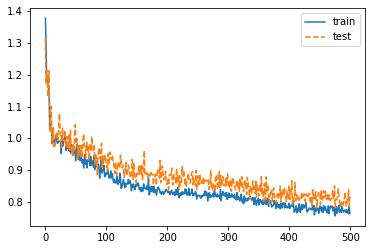

In [34]:
plt.plot(train_loss_AAPNN, '-', label='train')
plt.plot(test_loss_AAPNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_AAPNN)
AAPNN.load_state_dict(parameter_AAPNN)
best, test_loss_AAPNN[best]

In [35]:
optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=0.01)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_AAPNN, test_loss_AAPNN, parameter_AAPNN = tv.train_aged_pnn(AAPNN, train_loader, test_loader,
                                        m, T, M_train, K_train, M_test, K_test,
                                        optimizer_AAPNN, pnnv.LossFunction,
                                        Epoch=500, cache=ds)

  0%|          | 0/500 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.46662 | Loss: 0.805898070 |
| Epoch:    25 | Accuracy: 0.48708 | Loss: 0.799534917 |
| Epoch:    50 | Accuracy: 0.45365 | Loss: 0.822545767 |
| Epoch:    75 | Accuracy: 0.48299 | Loss: 0.809578538 |
| Epoch:   100 | Accuracy: 0.46552 | Loss: 0.811177433 |
| Epoch:   125 | Accuracy: 0.47061 | Loss: 0.809200168 |
| Epoch:   150 | Accuracy: 0.47137 | Loss: 0.839747965 |
| Epoch:   175 | Accuracy: 0.48309 | Loss: 0.830113769 |
| Epoch:   200 | Accuracy: 0.47495 | Loss: 0.807211578 |
| Epoch:   225 | Accuracy: 0.50098 | Loss: 0.785942852 |
| Epoch:   250 | Accuracy: 0.50211 | Loss: 0.777321577 |
| Epoch:   275 | Accuracy: 0.47598 | Loss: 0.808482409 |
| Epoch:   300 | Accuracy: 0.50916 | Loss: 0.774270356 |
| Epoch:   325 | Accuracy: 0.46122 | Loss: 0.816139996 |
| Epoch:   350 | Accuracy: 0.46463 | Loss: 0.819466352 |
| Epoch:   375 | Accuracy: 0.51735 | Loss: 0.770798087 |
| Epoch:   400 | Accuracy: 0.50976 | Loss: 0.797932863 |
| Epoch:   425 | Accuracy: 0.49

(420, 0.7670140266418457)

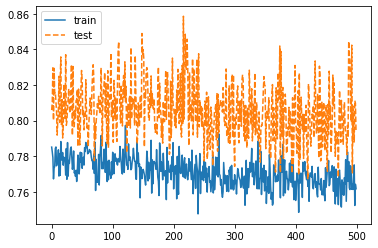

In [36]:
plt.plot(train_loss_AAPNN, '-', label='train')
plt.plot(test_loss_AAPNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_AAPNN)
AAPNN.load_state_dict(parameter_AAPNN)
best, test_loss_AAPNN[best]

In [37]:
optimizer_AAPNN = torch.optim.Adam(AAPNN.parameters(), lr=0.001)
train_loader = DataLoader(train_data, batch_size=len(train_data))
train_loss_AAPNN, test_loss_AAPNN, parameter_AAPNN = tv.train_aged_pnn(AAPNN, train_loader, test_loader,
                                        m, T, M_train, K_train, M_test, K_test,
                                        optimizer_AAPNN, pnnv.LossFunction,
                                        Epoch=500, cache=ds)

  0%|          | 0/500 [00:00<?, ?it/s]

| Epoch:     0 | Accuracy: 0.48840 | Loss: 0.798744857 |
| Epoch:    25 | Accuracy: 0.47537 | Loss: 0.825519562 |
| Epoch:    50 | Accuracy: 0.48324 | Loss: 0.813384056 |
| Epoch:    75 | Accuracy: 0.48801 | Loss: 0.816335440 |
| Epoch:   100 | Accuracy: 0.50404 | Loss: 0.786440432 |
| Epoch:   125 | Accuracy: 0.50127 | Loss: 0.782135367 |
| Epoch:   150 | Accuracy: 0.48122 | Loss: 0.811451733 |
| Epoch:   175 | Accuracy: 0.48253 | Loss: 0.802157640 |
| Epoch:   200 | Accuracy: 0.46861 | Loss: 0.810095847 |
| Epoch:   225 | Accuracy: 0.47887 | Loss: 0.803617299 |
| Epoch:   250 | Accuracy: 0.49610 | Loss: 0.782632768 |
| Epoch:   275 | Accuracy: 0.48296 | Loss: 0.810189605 |
| Epoch:   300 | Accuracy: 0.49731 | Loss: 0.789664567 |
| Epoch:   325 | Accuracy: 0.48331 | Loss: 0.820006788 |
| Epoch:   350 | Accuracy: 0.49267 | Loss: 0.787811875 |
| Epoch:   375 | Accuracy: 0.48042 | Loss: 0.819066107 |
| Epoch:   400 | Accuracy: 0.48686 | Loss: 0.815625608 |
| Epoch:   425 | Accuracy: 0.48

(214, 0.7629551887512207)

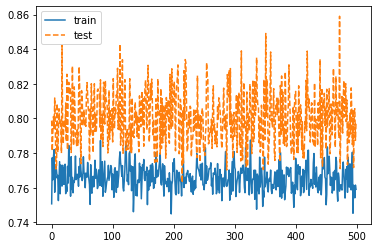

In [38]:
plt.plot(train_loss_AAPNN, '-', label='train')
plt.plot(test_loss_AAPNN, '--', label='test')
plt.legend()
best = np.argmin(test_loss_AAPNN)
AAPNN.load_state_dict(parameter_AAPNN)
best, test_loss_AAPNN[best]

## Save Model

In [39]:
with open(f'./result/{ds}_AAPNN_{seed}.p', 'wb') as f:
    pickle.dump(AAPNN, f)